# Install libraries
Machine Learning and Deep Learning Libraries

In [ ]:
pip install torch transformers datasets

In [ ]:
pip install seqeval

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json

from transformers import AutoTokenizer, BertForTokenClassification
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split, Dataset
from torch.nn.functional import pad
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from tqdm.auto import tqdm
from datasets import load_metric

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import color map to some scheme

In [ ]:
CYELGREENBG = '\033[43m'
CFUKSIABG = '\033[45m'
CLBLUEBG = '\033[46m'
CGREYBG    = '\33[100m'
CREDBG    = '\33[101m'
CGREENBG  = '\33[102m'
CYELLOWBG = '\33[103m'
CBLUEBG   = '\33[104m'
CVIOLETBG = '\33[105m'
CBEIGEBG  = '\33[106m'
CEND  = '\33[107m'

color_mapping = {'O': CEND, 'GEO': CYELLOWBG, 'GPE': CREDBG, 'PER': CBLUEBG, 'ORG':CVIOLETBG,
                 'TIM': CBEIGEBG, 'ART': CYELGREENBG, 'NAT': CFUKSIABG, 'EVE':CLBLUEBG
                 }

## Import existing dataset
Here we used dataset from kaggle

In [ ]:
data = pd.read_csv("NER dataset.csv", encoding='unicode_escape')
data.rename(columns={"Sentence #": "Sentence"}, inplace=True)
data["Tag"] = data["Tag"].apply(lambda x: x.upper())
data["TagGeneral"] = data["Tag"].apply(lambda x: x.split("-")[-1])
data["TagPos"] = data["Tag"].apply(lambda x: x.split("-")[0])
data["Word"].fillna("None", inplace=True)
data

,Sentence,Word,POS,Tag,TagGeneral,TagPos
0,Sentence: 1,Thousands,NNS,O,O,O
1,NaN,of,IN,O,O,O
2,NaN,demonstrators,NNS,O,O,O
3,NaN,have,VBP,O,O,O
4,NaN,marched,VBN,O,O,O
...,...,...,...,...,...,...
1048570,NaN,they,PRP,O,O,O
1048571,NaN,responded,VBD,O,O,O
1048572,NaN,to,TO,O,O,O
1048573,NaN,the,DT,O,O,O


In [ ]:
tag_list = data["Tag"].unique()
tag_general_list = data["TagGeneral"].unique()

n_tags = len(tag_list)
n_tag_general = len(tag_general_list)

tags2ids = {tag: i for i, tag in enumerate(tag_list)}
ids2tags = {i: tag for i, tag in enumerate(tag_list)}

data["TagId"] = data["Tag"].map(tags2ids)
data

,Sentence,Word,POS,Tag,TagGeneral,TagPos,TagId
0,Sentence: 1,Thousands,NNS,O,O,O,0
1,NaN,of,IN,O,O,O,0
2,NaN,demonstrators,NNS,O,O,O,0
3,NaN,have,VBP,O,O,O,0
4,NaN,marched,VBN,O,O,O,0
...,...,...,...,...,...,...,...
1048570,NaN,they,PRP,O,O,O,0
1048571,NaN,responded,VBD,O,O,O,0
1048572,NaN,to,TO,O,O,O,0
1048573,NaN,the,DT,O,O,O,0


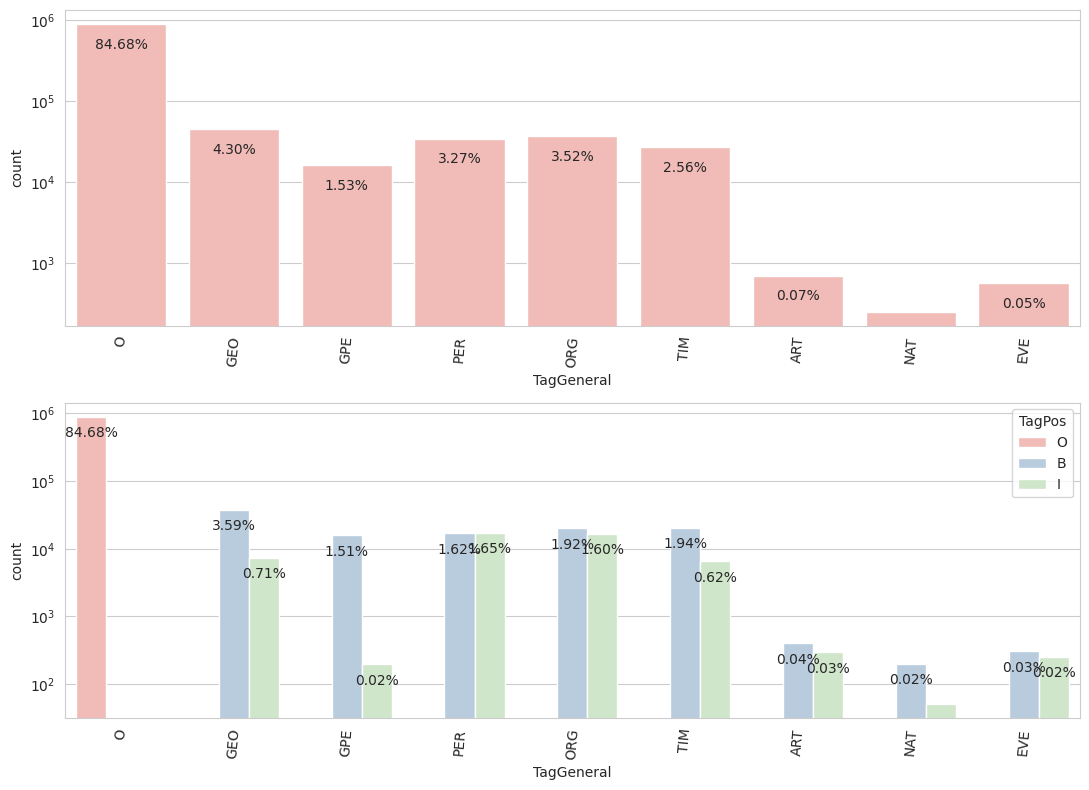

In [ ]:
sns.set_palette(palette="Pastel1")
sns.set_style("whitegrid")

fig, axs =plt.subplots(2,1, figsize=(11,8))
sns.countplot(x=data['TagGeneral'], ax=axs[0])
sns.countplot(x=data['TagGeneral'], ax=axs[1], hue =data["TagPos"])
axs[0].tick_params(axis='x', rotation=85)
axs[1].tick_params(axis='x', rotation=85)

total = len(data)
for ax in axs:
    ax.set_yscale("log")
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()/2
        ax.annotate(percentage, (x, y), ha='center', fontsize=10, rotation=0)
fig.tight_layout()
fig.show()

In [ ]:
data["Sentence"] = data["Sentence"].fillna(method='ffill')
data = data.groupby("Sentence").agg(list).reset_index().drop("Sentence", axis=1)
print(f"Number of records: {len(data)}")
data.head(7)

Number of records: 47959


,Word,POS,Tag,TagGeneral,TagPos,TagId
0,"[Thousands, of, demonstrators, have, marched, through, London, to, protest, the, war, in, Iraq, and, demand, the, withdrawal, of, British, troops, from, that, country, .]","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, NN, IN, NNP, CC, VB, DT, NN, IN, JJ, NNS, IN, DT, NN, .]","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GPE, O, O, O, O, O]","[O, O, O, O, O, O, GEO, O, O, O, O, O, GEO, O, O, O, O, O, GPE, O, O, O, O, O]","[O, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]"
1,"[Iranian, officials, say, they, expect, to, get, access, to, sealed, sensitive, parts, of, the, plant, Wednesday, ,, after, an, IAEA, surveillance, system, begins, functioning, .]","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, JJ, NNS, IN, DT, NN, NNP, ,, IN, DT, NNP, NN, NN, VBZ, VBG, .]","[B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-TIM, O, O, O, B-ORG, O, O, O, O, O]","[GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, O, TIM, O, O, O, ORG, O, O, O, O, O]","[B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, O, O, B, O, O, O, O, O]","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 5, 0, 0, 0, 0, 0]"
2,"[Helicopter, gunships, Saturday, pounded, militant, hideouts, in, the, Orakzai, tribal, region, ,, where, many, Taliban, militants, are, believed, to, have, fled, to, avoid, an, earlier, military, offensive, in, nearby, South, Waziristan, .]","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, NN, ,, WRB, JJ, NNP, NNS, VBP, VBN, TO, VB, VBN, TO, VB, DT, JJR, JJ, NN, IN, JJ, NNP, NNP, .]","[O, O, B-TIM, O, O, O, O, O, B-GEO, O, O, O, O, O, B-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO, O]","[O, O, TIM, O, O, O, O, O, GEO, O, O, O, O, O, ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, GEO, GEO, O]","[O, O, B, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, I, O]","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0]"
3,"[They, left, after, a, tense, hour-long, standoff, with, riot, police, .]","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[U.N., relief, coordinator, Jan, Egeland, said, Sunday, ,, U.S., ,, Indonesian, and, Australian, military, helicopters, are, ferrying, out, food, and, supplies, to, remote, areas, of, western, Aceh, province, that, ground, crews, can, not, reach, .]","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, JJ, CC, JJ, JJ, NNS, VBP, VBG, RP, NN, CC, NNS, TO, VB, NNS, IN, JJ, NNP, NN, IN, NN, NNS, MD, RB, VB, .]","[B-GEO, O, O, B-PER, I-PER, O, B-TIM, O, B-GEO, O, B-GPE, O, B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O, O, O, O, O, O, O]","[GEO, O, O, PER, PER, O, TIM, O, GEO, O, GPE, O, GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, GEO, O, O, O, O, O, O, O, O]","[B, O, O, B, I, O, B, O, B, O, B, O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, O, O]","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
5,"[Mr., Egeland, said, the, latest, figures, show, 1.8, million, people, are, in, need, of, food, assistance, -, with, the, need, greatest, in, Indonesia, ,, Sri, Lanka, ,, the, Maldives, and, India, .]","[NNP, NNP, VBD, DT, JJS, NNS, VBP, CD, CD, NNS, VBP, IN, NN, IN, NN, NN, :, IN, DT, NN, JJS, IN, NNP, ,, NNP, NNP, ,, DT, NNP, CC, NNP, .]","[B-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-TIM, O, B-PER, B-GPE, O, O, B-GEO, O, B-GEO, O]","[PER, PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, TIM, O, PER, GPE, O, O, GEO, O, GEO, O]","[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, B, B, O, O, B, O, B, O]","[3, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 3, 2, 

In [ ]:
def display_formatted_text(words, tags):
    formatted_text = " ".join([color_mapping[tag] + word for word, tag in zip(words, tags)]) + CEND
    print(formatted_text)

text = data.loc[1, "Word"]
tags = data.loc[1, "TagGeneral"]
display_formatted_text(text, tags)

text = data.loc[40, "Word"]
tags = data.loc[40, "TagGeneral"]
display_formatted_text(text, tags)

Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance system begins functioning .
The latest official death toll from that tragedy stands at some 1,76,000 people killed - 1,28,000 of them in Indonesia .


In [ ]:
huggingface_model = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(huggingface_model, do_lower_case=True)
tokenizer.special_tokens_map

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [ ]:
model = BertForTokenClassification.from_pretrained(
    huggingface_model,
    num_labels = n_tags,
    output_attentions = False,
    output_hidden_states = False,
).to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenization
* The **CustomDataset** class is designed for handling token-level labeling tasks with PyTorch.
* Takes a DataFrame containing words and their associated tags, and a tokenizer for encoding these words.
* Provides functionality to transform these inputs into a format suitable for training models on tasks like named entity recognition, where each token in the input text is assigned a label.

The tokenization step converts words to a numerical format that models can process, while maintaining necessary metadata like attention masks and token types, which are vital for the model's training and inference processes.

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.inputs = df["Word"].values
        self.labels =df["TagId"].values
        self.len = len(self.labels)

    def __getitem__(self, idx):
        encoded_dict = tokenizer(self.inputs[idx],
                                 is_split_into_words=True,
                                 add_special_tokens = True,
                                 return_attention_mask = True,
                                 return_tensors = 'pt',
                   )
        token_labels = self.__create_token_labels(self.labels[idx], encoded_dict.word_ids())
        return encoded_dict['input_ids'][0], encoded_dict['token_type_ids'][0], encoded_dict['attention_mask'][0], token_labels

    def __create_token_labels(self, labels, word_ids ):
        extended_labels = [-100 if word_id is None else labels[word_id] for word_id in word_ids]
        return torch.tensor(extended_labels).to(torch.int64)

    def __len__(self):
        return self.len

The **collate_fn** function is used for batching samples together, especially because samples are of different lengths. The step in this function are :

* **Determine Maximum Length**

* **Initialize Containers**: Four lists (ids, token_types, attention_masks, labels) are initialized to hold padded versions of input IDs, token type IDs, attention masks, and labels for each sample.
* **Pad and Collect Samples**:

* **Stack and Send to Device**: Each list is converted into a tensor.stack, and these tensors are moved to the specified GPU. This makes the batch ready for model processing, ensuring all inputs are of uniform size.

In [ ]:
def collate_fn(batch):
    max_len = max([len(sample[0]) for sample in batch])

    ids = []
    token_types = []
    attention_masks = []
    labels = []

    for sample in batch:
        pad_length = max_len - len(sample[0])
        ids.append(pad(sample[0], (0, pad_length), value=0))
        token_types.append(pad(sample[1], (0, pad_length), value=0))
        attention_masks.append(pad(sample[2], (0, pad_length), value=0))
        labels.append(pad(sample[3], (0, pad_length), value=-100))

    return torch.stack(ids).to(device), torch.stack(token_types).to(device), torch.stack(attention_masks).to(device), torch.stack(labels).to(device)

In [ ]:
dataset = CustomDataset(data, tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset)  - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(validation_size))

38,367 training samples
9,592 validation samples


In [ ]:
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )


In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

## Model Training and Validation

This section details the process for training and validating a neural network model using PyTorch across multiple epochs. The process includes monitoring training and validation losses, which help in evaluating the model's performance and convergence behavior.

### Setup

- `EPOCHS`: Defines the number of complete passes through the entire dataset.
- Arrays for metrics:
  - `avg_train_loss`: Stores average training loss per epoch.
  - `avg_val_loss`: Stores average validation loss per epoch.

### Training Process

For each epoch, the model undergoes the following steps:

1. **Training Mode**:
   - The model is set to training mode (`model.train()`), enabling specific layers like dropout layers to behave accordingly during training.

2. **Loop through Training Data**:
   - A tqdm progress bar wraps the training dataloader, providing a visual cue of progress.
   - For each batch:
     - Gradients are reset (`optimizer.zero_grad()`).
     - The model computes the loss based on the input and labels.
     - Loss is propagated backward (`loss.backward()`), and the optimizer updates the model parameters (`optimizer.step()`).
     - Running total of training loss is updated.
   - At the end of each epoch, calculate the average training loss and store it.

### Validation Process

After training, the model performs the following validation steps:

1. **Evaluation Mode**:
   - The model is switched to evaluation mode (`model.eval()`), which disables training-specific behaviors like dropout.

2. **Loop through Validation Data**:
   - With gradients disabled (`torch.no_grad()`), the validation dataloader is processed.
   - For each batch:
     - The model computes the loss without backpropagating it.
     - Running total of validation loss is updated.
   - Calculate and store the average validation loss per epoch.

### Metrics

Post training and validation, the average losses are stored in their respective arrays, which can be used for further analysis or reporting.

---

This routine ensures that each epoch's performance is accurately tracked, providing insights into the model's learning and generalization capabilities.


In [ ]:
EPOCHS = 3
avg_train_accuracy = []
avg_train_loss = []
avg_val_loss = []
avg_val_accuracy = []

for epoch_i in range(0, EPOCHS):
    running_train_loss = 0
    running_val_loss = 0
    model.train()
    loop = tqdm(train_dataloader)
    for batch in loop:

        optimizer.zero_grad()
        output = model(input_ids=batch[0],
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])

        loss = output.loss
        running_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        loop.set_description(f"Training. Epoch [{epoch_i}/{EPOCHS}]. Loss {loss.item()}")

    avg_train_loss.append(running_train_loss / train_size)

    model.eval()
    with torch.no_grad():
        loop = tqdm(validation_dataloader)
        for batch in loop:
            output = model(input_ids=batch[0],
                           token_type_ids=batch[1],
                           attention_mask=batch[2],
                           labels=batch[3])
            loss = output.loss
            running_val_loss += loss.item()
            loop.set_description(f"Validation. Epoch [{epoch_i}/{EPOCHS}]. Loss {loss.item()}")
    avg_val_loss.append(running_val_loss / validation_size)

  0%|          | 0/2398 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/2398 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/2398 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

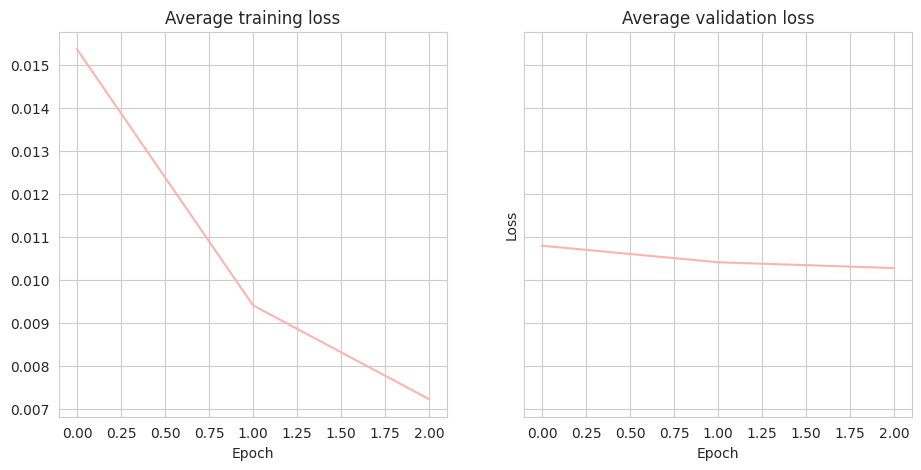

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(11, 5), sharex=True, sharey=True)

axs[0].plot(avg_train_loss)
axs[0].set_title("Average training loss")

axs[1].plot(avg_val_loss)
axs[1].set_title("Average validation loss")

axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

for row in axs:
     ax.grid(c='gray', alpha=0.5)

In [ ]:
def evaluate(model, dataloader):

    metric = load_metric("seqeval")

    all_predictions = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            output = model(input_ids=batch[0],
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])
            labels = batch[3].to('cpu').numpy()
            predictions = torch.argmax(output.logits.detach().cpu(), 2).numpy()

            for prediction, label in zip(predictions, labels):
                for pred_idx, label_idx in zip(prediction, label):
                    if label_idx != -100:
                        all_predictions.append(ids2tags[pred_idx])
                        all_labels.append(ids2tags[label_idx])



    data_result = metric.compute(predictions=[all_predictions], references=[all_labels])
    #print(data_result)
    df = pd.DataFrame(data_result).T  # Transpose
    df = df.drop(['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy'])

    # Setting up the bar plot
    n = len(df)
    r = np.arange(n)
    barWidth = 0.25

    fig, ax = plt.subplots(figsize=(14, 8))
    precision_bars = ax.bar(r, df['precision'], color='blue', width=barWidth, label='Precision')
    recall_bars = ax.bar(r + barWidth, df['recall'], color='green', width=barWidth, label='Recall')
    f1_bars = ax.bar(r + 2*barWidth, df['f1'], color='red', width=barWidth, label='F1 Score')

    # Adding labels
    ax.set_xlabel('Category', fontweight='bold')
    ax.set_ylabel('Scores', fontweight='bold')
    ax.set_xticks(r + barWidth)
    ax.set_xticklabels(df.index, rotation=45)
    ax.set_title('Precision, Recall, and F1 Score by Category')

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(precision_bars)
    add_labels(recall_bars)
    add_labels(f1_bars)

    ax.legend()
    plt.tight_layout()
    plt.show()
    return metric.compute(predictions=[all_predictions], references=[all_labels])


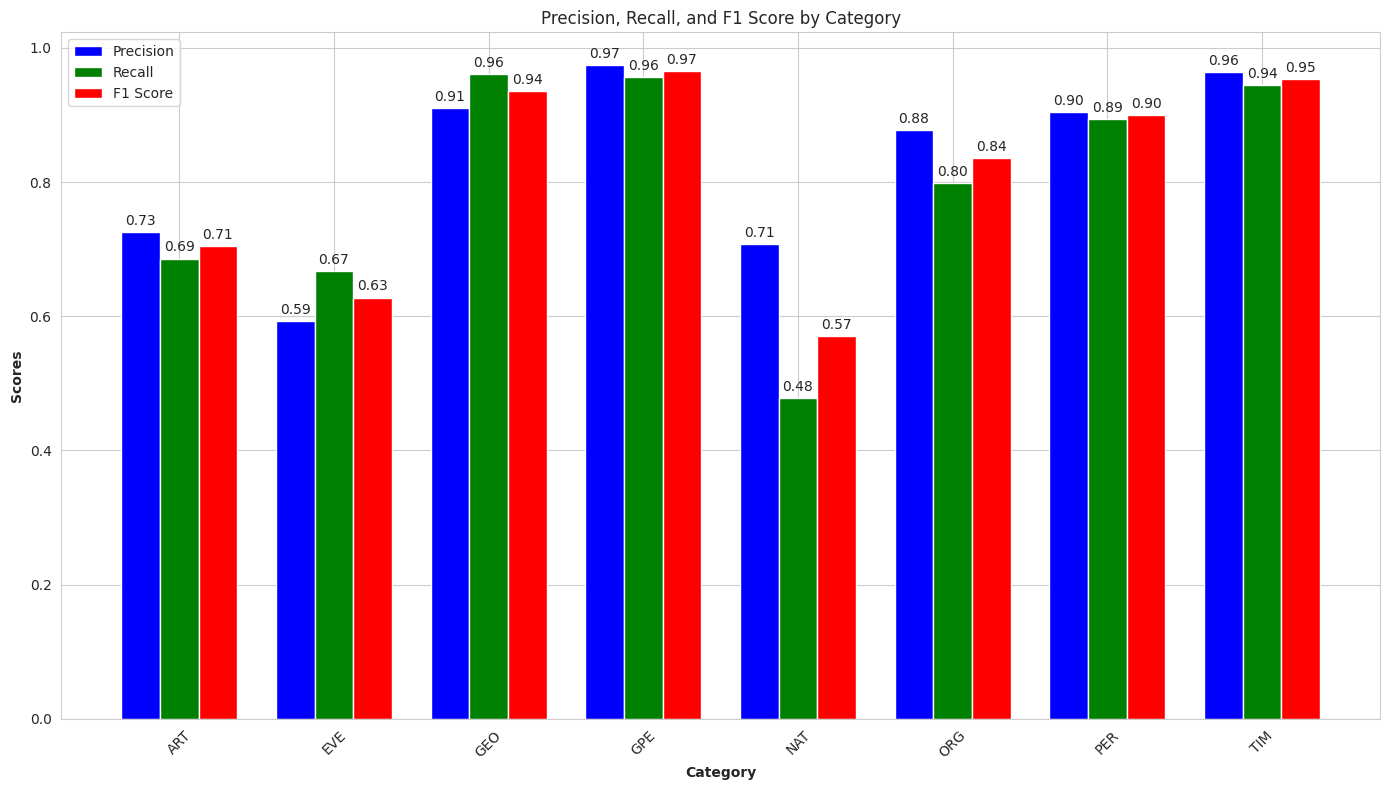

{'ART': {'precision': 0.7252604166666666,
  'recall': 0.6859605911330049,
  'f1': 0.7050632911392405,
  'number': 812},
 'EVE': {'precision': 0.5928270042194093,
  'recall': 0.667458432304038,
  'f1': 0.6279329608938548,
  'number': 421},
 'GEO': {'precision': 0.9106229967718589,
  'recall': 0.961324827786941,
  'f1': 0.9352872810510728,
  'number': 82456},
 'GPE': {'precision': 0.9745290527991509,
  'recall': 0.9570836699064544,
  'f1': 0.9657275822630049,
  'number': 38377},
 'NAT': {'precision': 0.7074829931972789,
  'recall': 0.4781609195402299,
  'f1': 0.5706447187928668,
  'number': 435},
 'ORG': {'precision': 0.8769511392859278,
  'recall': 0.7988396164741773,
  'f1': 0.8360749208883314,
  'number': 36712},
 'PER': {'precision': 0.9049555606572431,
  'recall': 0.8943376657051179,
  'f1': 0.899615284298383,
  'number': 30853},
 'TIM': {'precision': 0.9634240781557157,
  'recall': 0.9442984760903836,
  'f1': 0.9537654066167365,
  'number': 34254},
 'overall_precision': 0.921927786

In [ ]:
evaluate(model, train_dataloader)

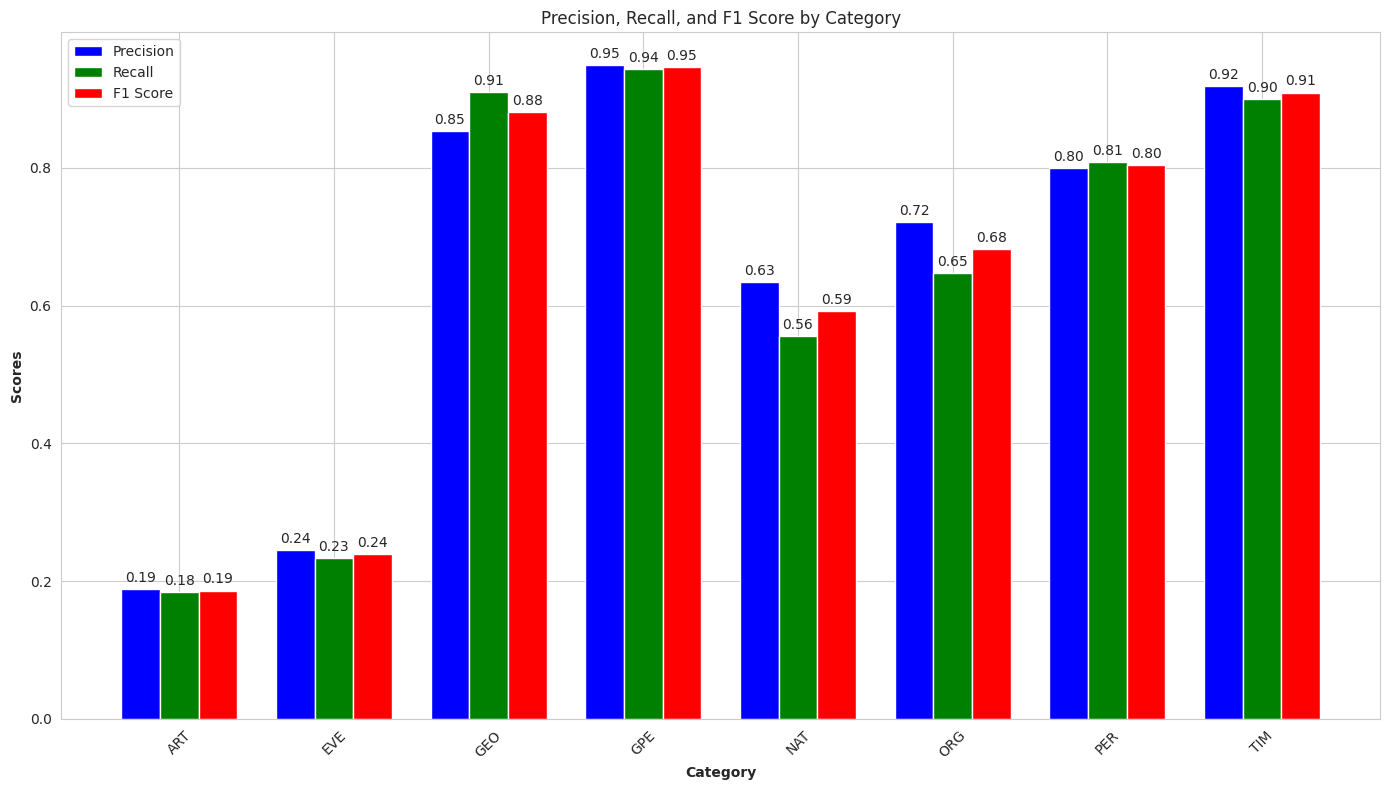

{'ART': {'precision': 0.1888111888111888,
  'recall': 0.1836734693877551,
  'f1': 0.18620689655172412,
  'number': 147},
 'EVE': {'precision': 0.24489795918367346,
  'recall': 0.23300970873786409,
  'f1': 0.23880597014925373,
  'number': 103},
 'GEO': {'precision': 0.8532975040991073,
  'recall': 0.9100403167047165,
  'f1': 0.8807559410478809,
  'number': 20587},
 'GPE': {'precision': 0.9495284485438905,
  'recall': 0.9433690280065898,
  'f1': 0.9464387170084189,
  'number': 9712},
 'NAT': {'precision': 0.6338028169014085,
  'recall': 0.5555555555555556,
  'f1': 0.5921052631578948,
  'number': 81},
 'ORG': {'precision': 0.7212432697014195,
  'recall': 0.6476923076923077,
  'f1': 0.6824918943955536,
  'number': 9100},
 'PER': {'precision': 0.8002246069378588,
  'recall': 0.8081915563957152,
  'f1': 0.8041883503667941,
  'number': 7935},
 'TIM': {'precision': 0.9191943127962086,
  'recall': 0.9001044204664114,
  'f1': 0.9095492115598804,
  'number': 8619},
 'overall_precision': 0.8499372

In [ ]:
evaluate(model, validation_dataloader)

In [ ]:
model.save_pretrained("ner_bert_model")
tokenizer.save_pretrained("tokenizer")

config = json.load(open("ner_bert_model/config.json"))
config["id2label"] = ids2tags
config["label2id"] = tags2ids
json.dump(config, open("ner_bert_model/config.json","w"))

# Function: get_predicted_tag and predict

**1. get_predicted_tag function**

The process is:
* Identify the Most Common Tag
* Adjust Scores
* Calculate Average Score
* Resolve Final Tag

**2. predict function**

The process is:
* Tokenize the Input
* Model Inference: Passes the tokenized input through the model to get raw scores.
* Extract Predictions
* Aggregate Results
* Handle Formatting



In [ ]:
from collections import Counter
import torch.nn.functional as F

def get_predicted_tag(word, tags, scores):
    most_common_tag = Counter(tags).most_common()[0][0]
    correct_scores = [score if tag == most_common_tag else -score for score, tag in zip(scores, tags)]
    score = round(sum(correct_scores)/len(correct_scores), 4)
    predicted_tag = ids2tags[most_common_tag].split("-")[-1]
    return {"word": word, "entity_group": predicted_tag, "score": score}


def predict(raw_text, display_formatted_text = True):

    raw_words = raw_text.split()
    encoded_dict = tokenizer(raw_words,
                             is_split_into_words=True,
                             add_special_tokens = True,
                             return_attention_mask = True,
                             return_tensors = 'pt'
                   )

    input_ids = encoded_dict['input_ids'][0].unsqueeze(0).to(device)
    input_token_type = encoded_dict['token_type_ids'][0].unsqueeze(0).to(device)
    input_mask = encoded_dict['attention_mask'][0].unsqueeze(0).to(device)

    output = model(input_ids, token_type_ids=input_token_type, attention_mask=input_mask)
    normalized_output = F.softmax(output.logits.detach().cpu(), dim=2)
    predictions = torch.max(normalized_output, 2)
    predicted_label = predictions.indices.numpy().flatten()
    predicted_scores = predictions.values.numpy().flatten()

    result = []
    prev_token_id = None

    for token_id, predicted_label, score in zip(encoded_dict.word_ids(), predicted_label, predicted_scores):
        if token_id is None:
            continue
        elif token_id != prev_token_id:
            if prev_token_id is not None:
                result.append(get_predicted_tag(raw_words[prev_token_id],tags, scores))
            tags = []
            scores = []

        tags.append(predicted_label)
        scores.append(score)
        prev_token_id = token_id

    result.append(get_predicted_tag(raw_words[prev_token_id],tags, scores))

    if display_formatted_text:
        formatted_text = " ".join([color_mapping[entity["entity_group"]] + entity["word"] for entity in result]) + CEND
        print(formatted_text)

    return result

In [ ]:
text = "Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country."
predict(text)

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country.


[{'word': 'Thousands', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'of', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'demonstrators', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'have', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'marched', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'through', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'London', 'entity_group': 'GEO', 'score': 0.9959},
 {'word': 'to', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'protest', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'the', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'war', 'entity_group': 'O', 'score': 0.9989},
 {'word': 'in', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'Iraq', 'entity_group': 'GEO', 'score': 0.9986},
 {'word': 'and', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'demand', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'the', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'withdrawal', 'entity_group': 'O', 'score': 0.9999},
 {'w

In [ ]:
text = "Dogs are the most variable mammal on earth with around 450 globally recognized dog breeds."
predict(text)

Dogs are the most variable mammal on earth with around 450 globally recognized dog breeds.


[{'word': 'Dogs', 'entity_group': 'O', 'score': 0.9721},
 {'word': 'are', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'the', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'most', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'variable', 'entity_group': 'O', 'score': 0.9997},
 {'word': 'mammal', 'entity_group': 'O', 'score': 0.9992},
 {'word': 'on', 'entity_group': 'O', 'score': 0.9993},
 {'word': 'earth', 'entity_group': 'GEO', 'score': 0.9141},
 {'word': 'with', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'around', 'entity_group': 'O', 'score': 0.9999},
 {'word': '450', 'entity_group': 'O', 'score': 0.9987},
 {'word': 'globally', 'entity_group': 'O', 'score': 0.9994},
 {'word': 'recognized', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'dog', 'entity_group': 'O', 'score': 0.9995},
 {'word': 'breeds.', 'entity_group': 'O', 'score': 0.9999}]